# input: 
seperate RFP and DAPI flourecent image pairs ( reffered to as red_img and blue_img)


In [20]:
# load images and set up paths


import numpy as np
from skimage.segmentation import expand_labels, watershed, find_boundaries
from scipy.ndimage import label as ndi_label, distance_transform_edt
import tifffile, cv2
from pathlib import Path
from skimage import morphology

notebook = Path(r"/home/phillip/documents/lysozyme/lysozyme-stain-quantification/docs/pipelineTheory.ipynb")

# go up to the project folder "lysozyme stain quantification"
project_root = notebook.parent.parent.parent



# Reuse existing 'pairs' if created earlier; otherwise build it quickly.
if 'pairs' not in globals():
    images_root = project_root / 'lysozyme images'
    red_files = sorted(list(images_root.rglob('*_RFP.tif')) + list(images_root.rglob('*_RFP.tiff')))
    def _match_blue(r_path: Path):
        stem = r_path.name
        if '_RFP.' not in stem:
            return None
        base = stem.split('_RFP.')[0]
        for ext in ['tif','tiff','TIF','TIFF']:
            cand = r_path.with_name(f'{base}_DAPI.{ext}')
            if cand.exists():
                return cand
        return None
    pairs = []
    for _r in red_files:
        b = _match_blue(_r)
        if b is not None:
            pairs.append((_r,b))
        if len(pairs) >= 30:
            break
    if not pairs:
        print('No RFP/DAPI pairs found. Aborting init cell.')

# Helper loaders (reuse if already defined).
if 'load_as_gray' not in globals():
    def load_as_gray(p: Path):
        arr = tifffile.imread(p)
        if arr.ndim == 3:
            if arr.shape[0] <= 4 and arr.shape[0] < arr.shape[-1]:
                arr = np.moveaxis(arr, 0, -1)
            if arr.shape[-1] in (3,4):
                arr = cv2.cvtColor(arr[..., :3].astype(np.uint8), cv2.COLOR_RGB2GRAY)
            else:
                arr = arr[...,0]
        return arr.astype(np.float32)
# Provided helper: minmax01
def minmax01(x, eps=1e-12):
    x = x.astype(float, copy=False)
    lo = np.min(x)
    hi = np.max(x)
    return (x - lo) / max(hi - lo, eps)


Using pair index 10: G2FB - 2_RFP.tif / G2FB - 2_DAPI.tif


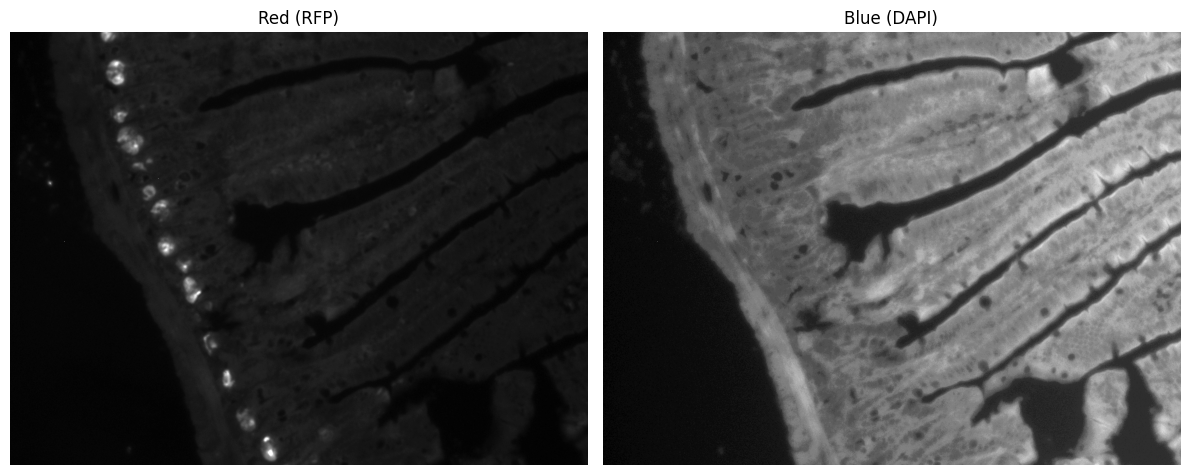

In [23]:

# pick a random pair from the first `max_samples` (change 30 to your desired cap)
if not pairs:
	print("No image pairs found. Please check your image folder or initialization code.")
else:
	max_samples = min(len(pairs), 30)
	idx = np.random.randint(0, max_samples)
	red_img = (minmax01(load_as_gray(pairs[idx][0]))*255.0).astype(np.float32)
	blue_img = (minmax01(load_as_gray(pairs[idx][1]))*255.0).astype(np.float32)
	blue = blue_img
	red = red_img  # DAPI, RFP
	print(f"Using pair index {idx}: {pairs[idx][0].name} / {pairs[idx][1].name}")
	import matplotlib.pyplot as plt

	r_disp = (red_img)
	b_disp = (blue_img)

	fig, axes = plt.subplots(1, 2, figsize=(12, 6))
	axes[0].imshow(r_disp, cmap='gray')
	axes[0].set_title('Red (RFP)')
	axes[1].imshow(b_disp, cmap='gray')
	axes[1].set_title('Blue (DAPI)')
	for ax in axes:
		ax.axis('off')
	plt.tight_layout()
	plt.show()


# pipeline:
    (red_image, blue_img) -> 
    grayscale ->  


## extractor_run: ->
    red_img & blue_img -> %%it looks like i dont normalize them%%
    prep grayscale masks: ->
        mask_r_dilation = np.maximum(blue, red) 
        mask_r_erosion = np.minimum(blue, red)
        %%these are np/ basicaly images of where each pixel value comes from whichever wins there%%
    


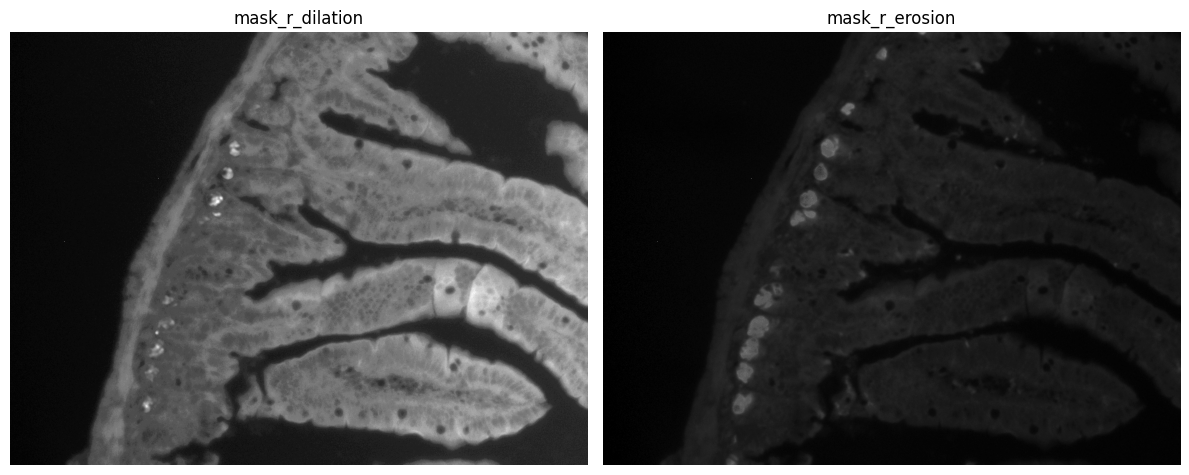

In [18]:
mask_r_dilation = np.maximum(blue, red); mask_r_erosion = np.minimum(blue, red)
r_disp_mask = minmax01(mask_r_dilation); e_disp_mask = minmax01(mask_r_erosion)
fig, axes = plt.subplots(1, 2, figsize=(12, 6)); axes[0].imshow(r_disp_mask, cmap='gray'); axes[0].set_title('mask_r_dilation'); axes[1].imshow(e_disp_mask, cmap='gray'); axes[1].set_title('mask_r_erosion')
for ax in axes: ax.axis('off')
plt.tight_layout(); plt.show()

    diff_r = bool where red stronger than min envelope: ->
        diff_r = red > mask_r_erosion
    clean up diff_r: ->
        binary erosion with a 3x3 square kernel ->
        remove small objects less then 100 px area ->
    
    abs_diff = Secondary mask using absolute difference: -> 
        abs of (mask_r_dilation - red)
        mask_gt_red = abs_diff > red (this is a bool)
    then create the eroded mask
        mask_gt_red_eroded = 2 iter of cv2 erode using 6x6 kernel on mask_gt_red

        get: (background_tissue_intensity, average_crypt_intensity)



    note: cant take combo straigt from imager as it preforms some sort of preproc that significantly changes the images, likely they are normalized on combined scales instead of seperate scales


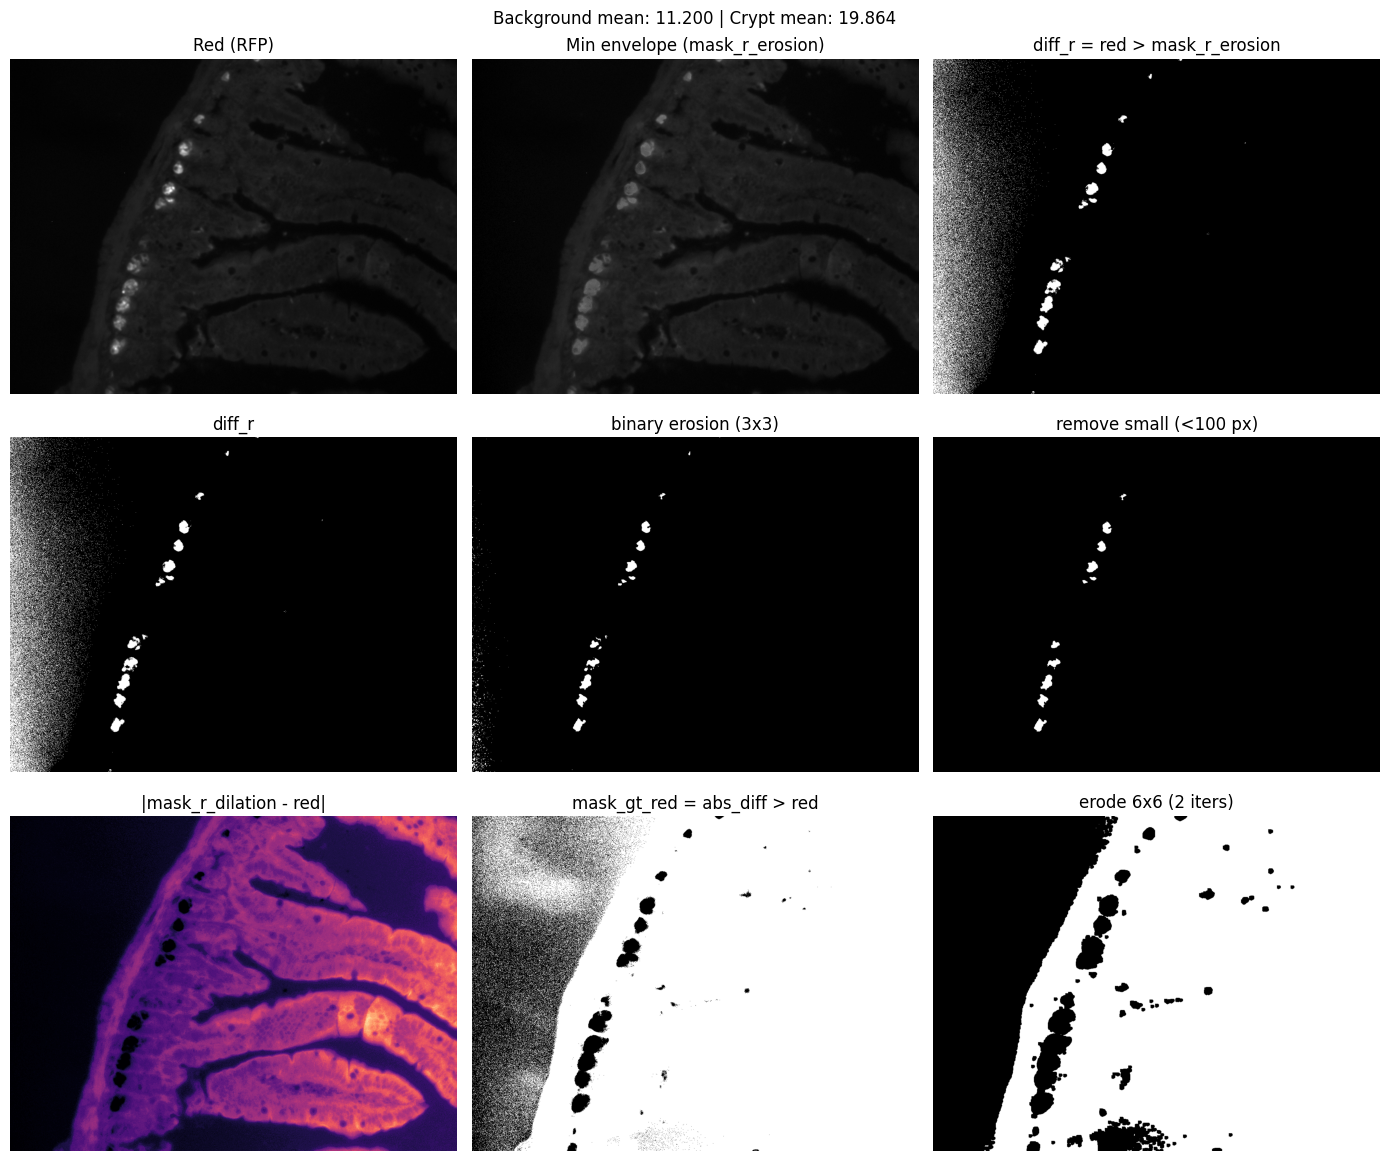

(11.19959831237793, 19.863582611083984)

In [19]:
# Visualize the red-vs-envelopes pipeline and compute summary intensities

# 1) Primary mask: red stronger than min envelope
diff_r = red > mask_r_erosion
diff_r_ero = morphology.binary_erosion(diff_r, footprint=np.ones((3, 3), dtype=bool))
diff_r_clean = morphology.remove_small_objects(diff_r_ero, min_size=100)

# 2) Secondary mask: absolute difference vs red, then erode with 6x6 (2 iters)
abs_diff = np.abs(mask_r_dilation - red)
mask_gt_red = abs_diff > red
erosion_kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (6, 6))
mask_u8 = (mask_gt_red.astype(np.uint8) * 255)
mask_eroded_u8 = cv2.erode(mask_u8, erosion_kernel, iterations=2)
mask_gt_red_eroded = mask_eroded_u8 > 0

# 3) Intensities
# Use the eroded secondary mask as "crypt" ROI; background = complement within tissue
tissue_mask = (mask_r_dilation > 0) | (mask_r_erosion > 0)
crypt_mask = mask_gt_red_eroded & tissue_mask
background_mask = (~crypt_mask) & tissue_mask

average_crypt_intensity = float(red[crypt_mask].mean()) if np.any(crypt_mask) else float("nan")
background_tissue_intensity = float(red[background_mask].mean()) if np.any(background_mask) else float("nan")

# 4) Render nice grid
red_disp = minmax01(red)
ero_disp = minmax01(mask_r_erosion)
abs_disp = minmax01(abs_diff)

fig_steps, axs = plt.subplots(3, 3, figsize=(14, 12))
axs = axs.reshape(3, 3)

# Row 1: red > min envelope -> diff_r
axs[0, 0].imshow(red_disp, cmap='gray');            axs[0, 0].set_title('Red (RFP)')
axs[0, 1].imshow(ero_disp, cmap='gray');            axs[0, 1].set_title('Min envelope (mask_r_erosion)')
axs[0, 2].imshow(diff_r, cmap='gray');              axs[0, 2].set_title('diff_r = red > mask_r_erosion')

# Row 2: cleanup diff_r -> erosion -> small objects removed
axs[1, 0].imshow(diff_r, cmap='gray');              axs[1, 0].set_title('diff_r')
axs[1, 1].imshow(diff_r_ero, cmap='gray');          axs[1, 1].set_title('binary erosion (3x3)')
axs[1, 2].imshow(diff_r_clean, cmap='gray');        axs[1, 2].set_title('remove small (<100 px)')

# Row 3: abs diff path -> threshold -> eroded mask
axs[2, 0].imshow(abs_disp, cmap='magma');           axs[2, 0].set_title('|mask_r_dilation - red|')
axs[2, 1].imshow(mask_gt_red, cmap='gray');         axs[2, 1].set_title('mask_gt_red = abs_diff > red')
axs[2, 2].imshow(mask_gt_red_eroded, cmap='gray');  axs[2, 2].set_title('erode 6x6 (2 iters)')

# Clean axes
for row in axs:
    for ax_ in row:
        ax_.axis('off')

fig_steps.suptitle(
    f'Background mean: {background_tissue_intensity:.3f} | Crypt mean: {average_crypt_intensity:.3f}',
    y=0.98
)
plt.tight_layout()
plt.show()

# Expose the requested summary values
background_tissue_intensity, average_crypt_intensity